# CA4015 - Recommender System - Assignment 3

The following assignment for CA4015 covers recommender systems and starts out with a basic implementation based on matrix factorization and then moves on to making use of neural network models to improve the predictions.

Section 1 - The Dataset

+ 1.1 - Reading in the data
+ 1.2 - Data cleaning
+ 1.3 - Data exploration

Section 2 - Recommender System Models

+ 2.1 - Data transformation
+ 2.2 - Matrix Factorization
+ 2.3 - Basic Retrieval Model
+ 2.4 - Basic Rank Model
+ 2.5 - Combining the Retrieval and Ranking
+ 2.6 - Advanced Retrieval Model
+ 2.7 - Conclusion

Section 3 - New User Recommendations

Section 4 - Conclusion

# Section 1 - The Dataset

The dataset to be used in this assignment is the Last.FM that can be found at [grouplens.org](https://grouplens.org/datasets/hetrec-2011/). The dataset consists of the following:

+ artists.dat - This file contains information about music artists listened and tagged by the users.
   
+ tags.dat - This file contains the set of tags available in the dataset.

+ user_artists.dat = This file contains the artists listened by each user. It also provides a listening count for each [user, artist] pair.

+ user_taggedartists.dat & user_taggedartists-timestamps.dat - These files contain the tag assignments of artists provided by each particular user. They also contain the timestamps when the tag assignments were done.
   
+ user_friends.dat - These files contain the friend relations between users in the database.

We will make use of as many features from this dataset as possible to inform our predictions from various models. We will start with a more basic model and work up to hopefully include all features.

## 1.1 Reading in the data

The data has been uploaded to Google Drive, so I will mount my drive and read the data from there.

In [1]:
from google.colab import drive
# Mount my drive at the following location
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I will also import the libraries that I'm going to need in this section.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Now I can start to read in the data. When reading in the tag data I was returned a decoding error, as the default utf-8 was not able to decode the data. After some Googling and trial-and-error, I have found that the basic encoding iso-8859-1, also known as latin-1, seems to do the trick for these files.

In [3]:
user_artists = pd.read_csv("drive/MyDrive/CA4015/hetrec2011-lastfm-2k/user_artists.dat", sep="\t", encoding="iso-8859-1")
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
artists = pd.read_csv("drive/MyDrive/CA4015/hetrec2011-lastfm-2k/artists.dat", sep="\t", encoding="iso-8859-1")
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
tags = pd.read_csv("drive/MyDrive/CA4015/hetrec2011-lastfm-2k/tags.dat", sep="\t", encoding="iso-8859-1")
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
tagged_timestamp = pd.read_csv("drive/MyDrive/CA4015/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat", sep="\t", encoding="iso-8859-1")
tagged_timestamp.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [7]:
user_friends = pd.read_csv("drive/MyDrive/CA4015/hetrec2011-lastfm-2k/user_friends.dat", sep="\t", encoding="iso-8859-1")
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


I will not be using the user_taggedartists.dat as it contains the same data as user_taggedartists-timestamps.dat just with the day, month and year in place of the timestamp, which is easier to process.

Now that we have all of our data read in, let us assess the quality by checking for nulls.

## 1.2 Data cleaning

We will loop through the data frames and check for any nulls.

We will merge user_artists and artists, and tags and tagged_timestamp for the moment. This will leave us with 3 dataframes, full_user_artists, tags_timestamp and user_friends.

In [140]:
dfs = [user_artists, artists, tags, tagged_timestamp, user_friends]

In [195]:
for df in dfs:
  print(df.isnull().values.any())

False
True
False
False
False


It seems that our artist dataframe has nulls present. Let us dive further into this and invertigate these nulls.

In [196]:
artists.isnull().any()

id            False
name          False
url           False
pictureURL     True
dtype: bool

In [197]:
artists[artists.isnull().any(axis=1)]

,id,name,url,pictureURL
105,111,Pleq & Anna Rose Carter,http://www.last.fm/music/+noredirect/Pleq%2B%2...,NaN
113,119,billy gomberg + offthesky,http://www.last.fm/music/+noredirect/billy%2Bg...,NaN
118,124,Shinkei & Mise En Scene,http://www.last.fm/music/Shinkei%2B%2526%2BMis...,NaN
127,133,Lauki,http://www.last.fm/music/Lauki,NaN
392,398,www.DjFahad.com,http://www.last.fm/music/www.DjFahad.com,NaN
...,...,...,...,...
17504,18601,uwe hÃ¼bner-der deutsche hitmix,http://www.last.fm/music/uwe+h%C3%BCbner-der+d...,NaN
17525,18622,Pete Hopkins,http://www.last.fm/music/Pete+Hopkins,NaN
17542,18646,shaggy and big yard crew,http://www.last.fm/music/shaggy+and+big+yard+crew,NaN
17544,18648,Ramin Djawadi And The RZA,http://www.last.fm/music/Ramin+Djawadi+And+The...,NaN


We can see that the only nulls are in the pictureURL column, which is not an important feature for making predictions, which is lucky as this is not a value we can impute. If this value was needed, the solution would possibly be to webscrape Last.FM to find the URL for a page relating to an artist.

In [8]:
# Rename the id column in artists to artistID to make merge less verbose and more clear.
artists.rename({"id": "artistID"}, axis=1, inplace=True)
full_user_artists = pd.merge(user_artists, artists, on="artistID")
full_user_artists.head()

,userID,artistID,weight,name,url,pictureURL
0,2,51,13883,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,4,51,228,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
2,27,51,85,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
3,28,51,10,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
4,62,51,528,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg


In [142]:
full_user_artists.shape

(92834, 6)

With a quich sanity check we can see that there are ~92,800 records which matches the description of the dataset.

Now we can join the tags data

In [9]:
tags_timestamp = pd.merge(tags, tagged_timestamp, on="tagID")
tags_timestamp.head()

,tagID,tagValue,userID,artistID,timestamp
0,1,metal,4,918,1209592800000
1,1,metal,12,181,1272664800000
2,1,metal,12,198,1264978800000
3,1,metal,12,500,1264978800000
4,1,metal,12,503,1267398000000


In [10]:
assert tagged_timestamp.shape[0] == tags_timestamp.shape[0]

After another sanity check, we can see that the number of rows has not changed after merging the data, which means we have not lost or gained any new records.

## 1.3 Data exploration

Now that we have joined some of the related data, we can take a look at the data and try to understand it with some more of an analysis. We will be taking a look at several features using exporatory visualisations.

+ The distribution of tag values and the most popular tags
+ User listens as a distribution and top users
+ Artist listens distribution and top artists
+ Distribution of friends per user

### Tags

In [58]:
# Group the tags by the tag ID and value, just to keep both values
tag_count = tags_timestamp[["tagID", "tagValue", "artistID"]].groupby(by=["tagID", "tagValue"]).count()
tag_count = tag_count.rename({"artistID": "Count"}, axis=1).sort_values("Count", ascending=False).reset_index()

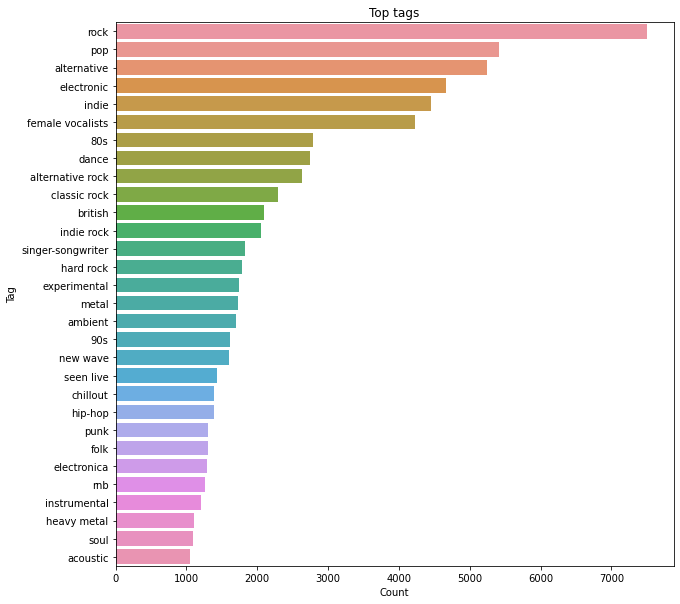

In [127]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x="Count", y="tagValue", data=tag_count[:30])

plt.title("Top tags")
plt.ylabel("Tag")

plt.show()

We can see that the top tags relate to music genres and then some very broad tags such as female vosalists and 80s which can apply to many tracks.

There is a steep drop after the first 6 tags, and by the 30th we are down to less than 1/7th of the top tag.

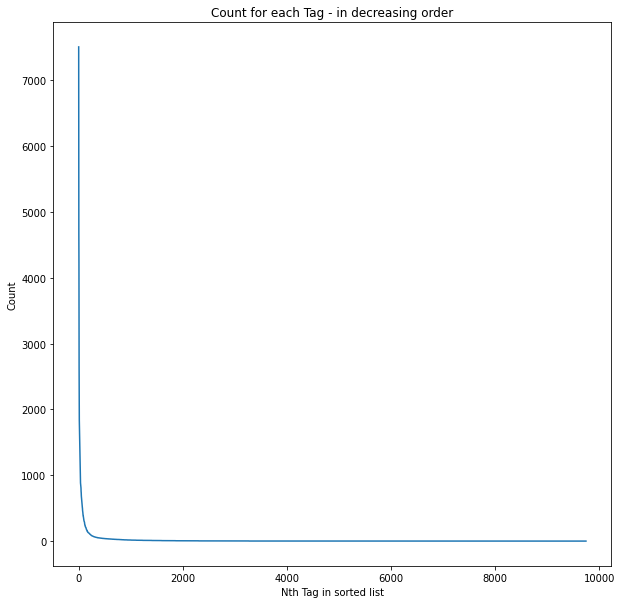

In [128]:
f, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x=tag_count.index, y="Count", data=tag_count)


plt.title("Count for each Tag - in decreasing order")
plt.xlabel("Nth Tag in sorted list")
plt.ylabel("Count")

plt.show()

As we had seen when we looked at the top tags, there is a steep drop as we move down the sorted values. After roughly 250 tags it seems we are virtually at the floor.

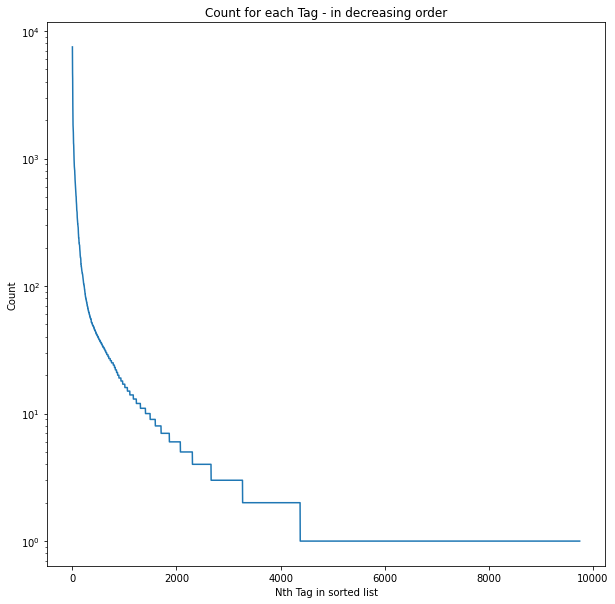

In [129]:
f, ax = plt.subplots(figsize=(10, 10))

line_p = sns.lineplot(x=tag_count.index, y="Count", data=tag_count)
line_p.set(yscale="log")

plt.title("Count for each Tag - in decreasing order")
plt.xlabel("Nth Tag in sorted list")
plt.ylabel("Count")

plt.show()

Looking at this log scaled plot of the same data, we can see that at about 1,500 into the list the tags have 10 occurances or less. At about 4,250 tags in we are down to 1 occurence for each tag.

We can see that the tags outside of the first 2,000 most common tags are quite under-represented in the data.

Users

In [130]:
user_listens = full_user_artists[["userID", "weight"]].groupby(by=["userID"]).sum()
user_listens = user_listens.sort_values("weight", ascending=False).rename({"weight": "Total_listens"}, axis=1).reset_index()

In [131]:
# Convert the userID to a string so we can use it for plotting as a name and not a value
user_listens['userID'] = user_listens['userID'].astype(str)

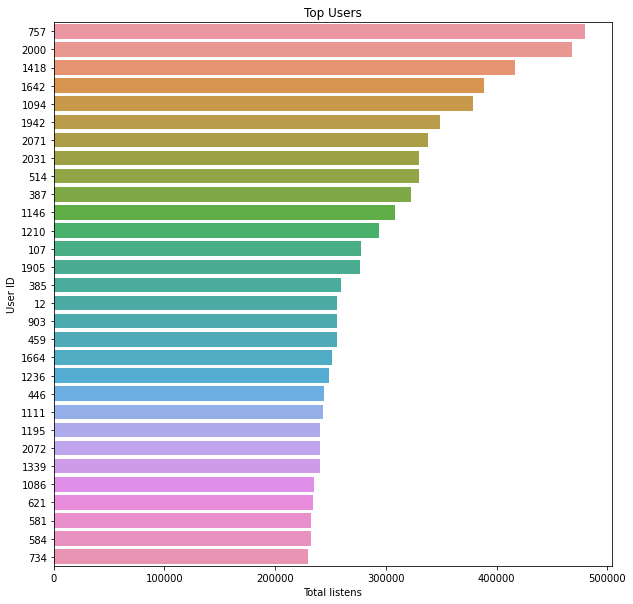

In [132]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x="Total_listens", y="userID", data=user_listens[:30])

plt.title("Top Users")
plt.xlabel("Total listens")
plt.ylabel("User ID")

plt.show()

We can see from the above barchart that the user listens has a steep drop after after the first couple of users. Towards the end of the top 30 we can see the change between users is much smaller, and I would predict continues this way, resulting in a right skewed distribution.

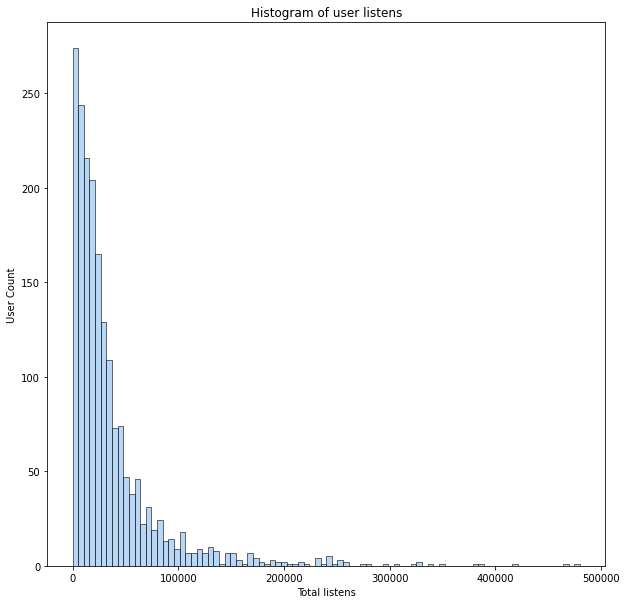

In [136]:
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("pastel")
sns.histplot(data=user_listens, x="Total_listens", color="b")

plt.title("Histogram of user listens")
plt.xlabel("Total listens")
plt.ylabel("User Count")

plt.show()

This histogram makes our earlier observations clear, there is a large skew to the right in the distribution. Majority of the users have less than 100,000 listens. This shows that many users are not overly active as many have relatively few listens.

Artists

In [119]:
artist_listens = full_user_artists[["name", "weight"]].groupby(by=["name"]).sum()
artist_listens = artist_listens.sort_values("weight", ascending=False).rename({"weight": "Total_listens"}, axis=1).reset_index()

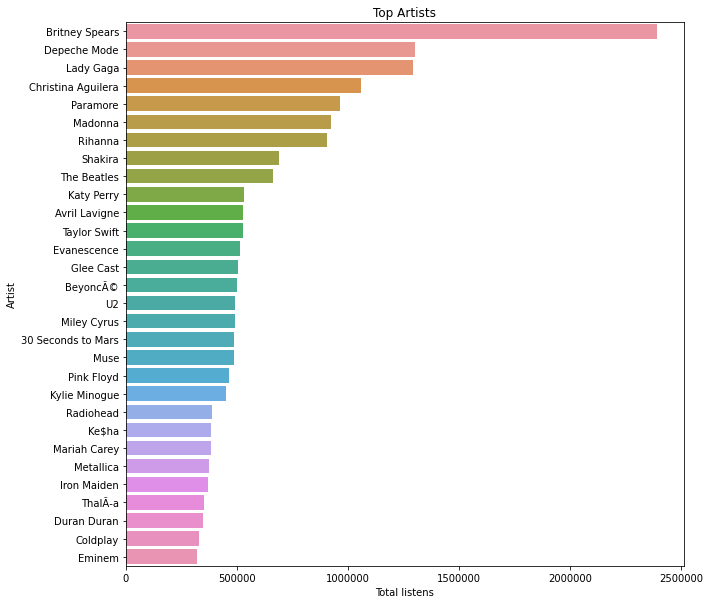

In [157]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x="Total_listens", y="name", data=artist_listens[:30])

plt.ticklabel_format(style='plain', axis='x')
plt.title("Top Artists")
plt.xlabel("Total listens")
plt.ylabel("Artist")

plt.show()

It seems Britney Spears is the top artist with almost twice the listens as the next artist down at 2.4 million listens. We can see again that there is a steep drop. This indicates that there may be a right-skew in the data.

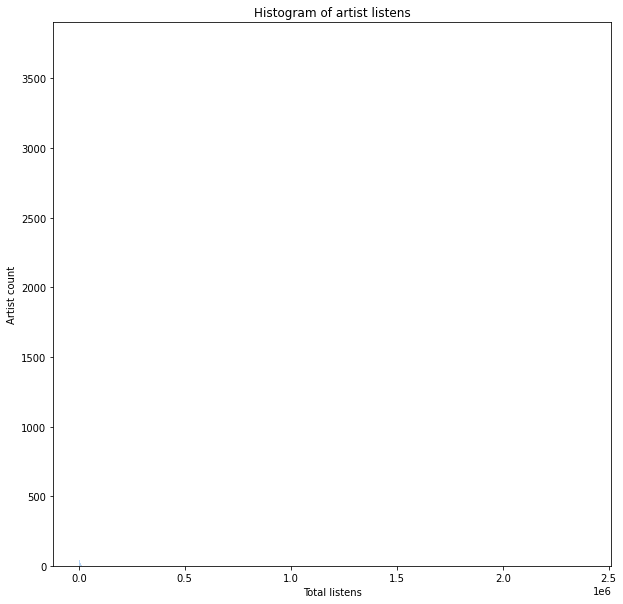

In [148]:
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("pastel")
sns.histplot(data=artist_listens, x="Total_listens", color="b")


plt.title("Histogram of artist listens")
plt.xlabel("Total listens")
plt.ylabel("Artist count")

plt.show()

We can see that the histogram has trouble displaying the data due to the collosal difference in values between the top artist and artists that are not as well known.

Let us scale the x-axis as a log and see if the visualisation is any better.

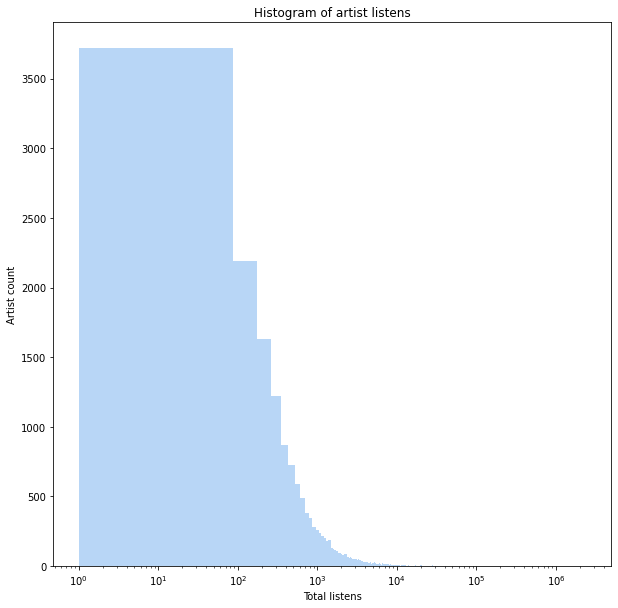

In [159]:
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("pastel")
hist_p = sns.histplot(data=artist_listens, x="Total_listens", color="b")
hist_p.set(xscale="log")

plt.title("Histogram of artist listens")
plt.xlabel("Total listens")
plt.ylabel("Artist count")

plt.show()

We can see that over 3,500 artists have between 0 and 100 listens. There are not many artists with more than 10,000 listens it can be seen. Past 10,000 listens there are much smaller groups of artists. Even though this visualisation is log scaled, we can see that the data is right-skewed.

User friends

In [152]:
user_friend_count = user_friends.groupby(by=["userID"]).count()
user_friend_count = user_friends.rename({"friendID": "Count"}, axis=1).sort_values("Count", ascending=False).reset_index()

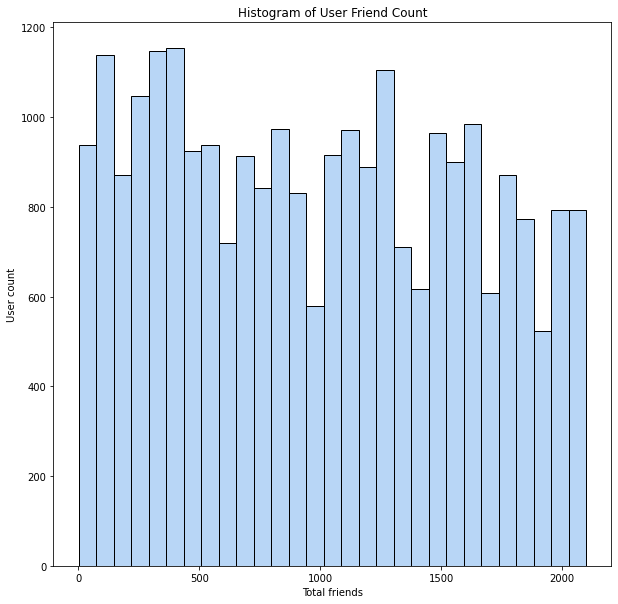

In [156]:
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("pastel")
sns.histplot(data=user_friend_count, x="userID", color="b")

plt.title("Histogram of User Friend Count")
plt.xlabel("Total friends")
plt.ylabel("User count")

plt.show()

It seems that the users are well distributed with regards to the number of friends they have. The distribution is not unsimilar to that of a uniform distribution.

Now that we have thoroughly looked at our data and how it is distributed, we can now look at creating our models.

# Section 2 - Recommender System Models

We will now look at making use of several models of varying difficult to create recommendations. These will be in increasing order of complexity. These models are based off of the tutorial provided by [Tensorflow for recommender systems](https://www.tensorflow.org/recommenders/examples/quickstart).

These models are as follows:

+ Collaborative filtering using matrix factorization
+ Basic ranking in Tensorflow
+ Using additional features
+ Custom implementation with user relations

These models are mostly pieces adapted from the tutorials with changes to fit this data, I will evaluate each and see if I can make improvements with my own theory in the last model.

## 2.1 Setup and Data transformation

Thus far we have not had to shift the IDs so they are contiguous, but this may be a good decision as matrix factorization uses these IDs along the columns of the user and item matrices.

We will only do this for matrix factorization and our later model will not need this. So we will just change this for the user and artist ID in the full_user_artists table and ignore occurences in the other data.

In [47]:
ratings_table = full_user_artists.copy()

In [48]:
# We can use np.unique(return_inverse=True) to get an array the same length as the input with the indexes
# of the first occurence of each unique value. Which is just what we need.
_, new_column = np.unique(ratings_table["userID"].values, return_inverse=True)
ratings_table["userID"] = new_column

In [49]:
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
old_column = ratings_table["artistID"].values
old_new_mapping = {k:v for k, v in zip(old_column, new_column)}

ratings_table["artistID"] = new_column
artists["artistID"] = artists["artistID"].apply(lambda x: old_new_mapping[x])

In [50]:
# Sanity check against the original
len(np.unique(full_user_artists["artistID"].values)) == len(np.unique(ratings_table["artistID"].values))

True

Next, we have multiple user-defined tags for each artist. In order the visualise these in a coherent way, it would be worth taking the most popular tag for each artist. In this way we are eliminating the unpopular and likely not relevant or valid tags in favour of the most accepted tag for an artist.

In [51]:
artist_tag = {}

# for every artist, count all their tags and take the most popular into our mapping
for artist in tags_timestamp["artistID"].unique():
  values, counts = np.unique(tags_timestamp[tags_timestamp["artistID"] == artist]["tagValue"].values, return_counts=True)
  most_used = values[counts == counts.max()]
  artist_tag[artist] = most_used[0]


In [52]:
def map_tags(value):
  if value in artist_tag.keys():
    return artist_tag[value]
  else:
    return "No Tag"

In [53]:
ratings_table["Tag"] = ratings_table.apply(lambda x: map_tags(x["artistID"]), axis=1)
artists["Tag"] = artists.apply(lambda x: map_tags(x["artistID"]), axis=1)

Lastly, we need to consider the rating, or in this case the implicit rating of listens. Here we have got a continuous attribute as opposed to the typical ordinal of a 1-5 rating. If we don't address this we may get recommendations that are highly weighted towards the high values in the matrix.

To fix this we will need to change these values to either be binary or to fit into some groupings that we decide. As fitting the data to these groupings or ranges will preserve some data relating to how much a user likes an artist I have opted for this appraoch.

The following is what I have decided:

+ 0 - A user has not listened to an artist
+ 1 - A user has listened to an artist once
+ 2 - A user has listened to an artist 2-1000 times
+ 3 - A user has listened to an artist 1001-10000 times
+ 4 - A user has listened to an artist 10001-50000 times
+ 5 - A user has listened to an artist 50000+ times

This should capture much of the data relative to a user liking a artist. If a user listens to an artist only once we can extrapolate that they didn't enjoy the listen.

In [54]:
def listening_mapping(value):
  if value == 1:
    return 1
  elif value <= 1000:
    return 2
  elif value <= 10000:
    return 3
  elif value <= 50000:
    return 4
  else:
    return 5

In [55]:
ratings_table["Implicit_rating"] = ratings_table.apply(lambda x: listening_mapping(x["weight"]), axis=1)

In [56]:
ratings_table[ratings_table["Implicit_rating"] == 5]

,userID,artistID,weight,name,url,pictureURL,Tag,Implicit_rating
32,400,45,61012,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,punk,5
77,1103,45,103150,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,punk,5
541,183,50,84980,Daft Punk,http://www.last.fm/music/Daft+Punk,http://userserve-ak.last.fm/serve/252/10923145...,industrial,5
1246,1213,59,78496,Coldplay,http://www.last.fm/music/Coldplay,http://userserve-ak.last.fm/serve/252/67770.jpg,new wave,5
2063,198,66,56884,Depeche Mode,http://www.last.fm/music/Depeche+Mode,http://userserve-ak.last.fm/serve/252/75022.jpg,electronic,5
...,...,...,...,...,...,...,...,...
38423,292,908,82773,Iron Maiden,http://www.last.fm/music/Iron+Maiden,http://userserve-ak.last.fm/serve/252/22493569...,pop,5
49469,1802,1435,50559,Akon,http://www.last.fm/music/Akon,http://userserve-ak.last.fm/serve/252/35787629...,ballad,5
55867,1293,2029,60845,Sarah Brightman,http://www.last.fm/music/Sarah+Brightman,http://userserve-ak.last.fm/serve/252/49885835...,ska,5
56953,879,2164,64223,50 Cent,http://www.last.fm/music/50+Cent,http://userserve-ak.last.fm/serve/252/32353091...,idm,5


In [57]:
ratings_table.drop(["url", "pictureURL", "weight"], axis=1, inplace=True)

In [58]:
ratings_table

,userID,artistID,name,Tag,Implicit_rating
0,0,45,Duran Duran,punk,4
1,2,45,Duran Duran,punk,2
2,24,45,Duran Duran,punk,2
3,25,45,Duran Duran,punk,2
4,59,45,Duran Duran,punk,2
...,...,...,...,...,...
92829,1891,17615,Nyktalgia,comedy,2
92830,1891,17616,Atsakau niekadA,comedy,2
92831,1891,17617,Domantas Razauskas,No Tag,2
92832,1891,17618,Atalyja,comedy,2


Now that the IDs are shifted, the genre is set and we have out implicit rating values we can proceed with training a collaborative filtering model using the matrix factorization approach.

### Altair Setup

Altair is used for creating interactive visualisation in Colab

In [144]:
# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-10_tr8j4
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-10_tr8j4
  fatal: unable to connect to github.com:
  github.com[0: 140.82.112.3]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-10_tr8j4 Check the logs for full command output.
Done installing Altair.


In [145]:
def item_embedding_norm(ratings, models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = ratings[["name", "Tag", "Implicit_rating"]].groupby(by=["name", "Tag"]).count().rename({"Implicit_rating": "num_ratings"}, axis=1).reset_index()

  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["artistID"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'name', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

tag_filter = alt.selection_multi(fields=['Tag'])
tag_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('Tag'),
    color=alt.condition(
        tag_filter,
        alt.Color("Tag:N"),
        alt.value('lightgray'))
).properties(height=600, selection=tag_filter)

def visualize_item_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(tag_filter, "Tag", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), tag_chart, data=data)

def tsne_artist_embeddings(ratings, model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["artistID"])
  ratings.loc[:,'x'] = V_proj[:, 0]
  ratings.loc[:,'y'] = V_proj[:, 1]
  return visualize_item_embeddings(ratings, 'x', 'y')

## 2.2 Matrix Factorization

We will import helper functions that were defined in the collaborative filtering tutorial to setup the model.

These can be stored in a .py file to save space here. The Altair functions have to be in the notebook as they use !pip and this cannot be ran through a .py file.

In [142]:
from CFUtils import build_rating_sparse_tensor, split_dataframe, sparse_mean_square_error, build_model, CFModel, user_recommendations, compute_scores, artist_neighbors, gravity, build_regularized_model
import sklearn
import tensorflow.compat.v1 as tf

Instructions for updating:
non-resource variables are not supported in the long term


 iteration 1000: train_error=0.139010, test_error=1.023590

[{'train_error': 0.1390101, 'test_error': 1.0235901}]

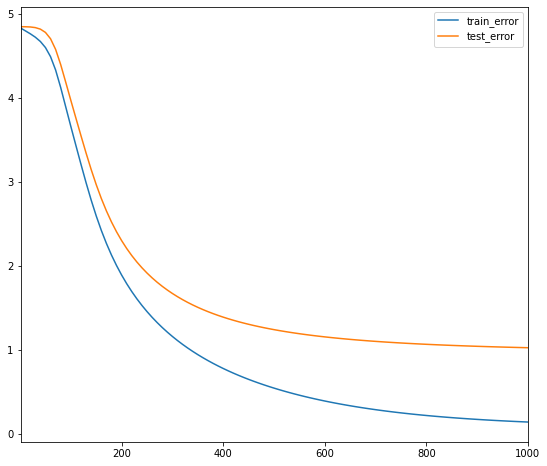

In [27]:
# Pass our ratings to the model and train it
matrix_fac = build_model(ratings_table, embedding_dim=12, init_stddev=0.25)
matrix_fac.train(num_iterations=1000, learning_rate=10.)

We can see the train and test error above. It seems that the model is not improving anymore and more iterations would likely lead to overfitting.

As an initial test, we can compute the similarty between artists to find artists close to the artist in question. We will take a look at a few of these. We have two options for similarity measure, the dot product and cosine similarity. The dot product is likely to be more sensitive to a large norm than the cosine similarity.

In [157]:
artist_neighbors(matrix_fac, artists, "Eminem", measure="dot", k=6)

Nearest neighbors of : Eminem.
[Found more than one matching artist. Other candidates: Eminem & Royce Da 5'9", 50 Cent, Eminem, Ca$his & Lloyd Banks, DJ Messiah, 50 Cent And Eminem, Eminem feat. Drake, Kanye West, Lil Wayne, B.o.B feat. Eminem & Hayley Williams, Eminem ft. Xzibit & Nate Dogg, Eminem ft. Nate Dogg, Dr. Dre, Eminem Ft. Trick Trick, BOB, Hayley Williams and Eminem, \Eminem f_ Rihanna]


,dot score,name
469,2.364,Eminem
535,2.285,Space Cowboy
432,2.238,O Teatro MÃ¡gico
3637,2.187,The Lonely Island
353,2.170,Maria Mena
1960,2.156,O.S.T.R.


In [158]:
artist_neighbors(matrix_fac, artists, "Eminem", measure="cosine", k=6)

Nearest neighbors of : Eminem.
[Found more than one matching artist. Other candidates: Eminem & Royce Da 5'9", 50 Cent, Eminem, Ca$his & Lloyd Banks, DJ Messiah, 50 Cent And Eminem, Eminem feat. Drake, Kanye West, Lil Wayne, B.o.B feat. Eminem & Hayley Williams, Eminem ft. Xzibit & Nate Dogg, Eminem ft. Nate Dogg, Dr. Dre, Eminem Ft. Trick Trick, BOB, Hayley Williams and Eminem, \Eminem f_ Rihanna]


,cosine score,name
469,1.000,Eminem
535,0.957,Space Cowboy
7600,0.939,Scouting for Girls
529,0.937,Sophie Ellis-Bextor
959,0.931,Armin van Buuren
716,0.925,ATB


In [159]:
artist_neighbors(matrix_fac, artists, "The Beatles", measure="dot", k=6)

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,dot score,name
221,2.235,The Beatles
433,2.144,Los Hermanos
1960,2.102,O.S.T.R.
4171,2.066,Kill Hannah
2404,2.042,Billie Holiday
3693,2.035,Shiny Toy Guns


In [160]:
artist_neighbors(matrix_fac, artists, "The Beatles", measure="cosine", k=6)

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,cosine score,name
221,1.000,The Beatles
153,0.971,The Cure
527,0.971,Oasis
148,0.970,Radiohead
430,0.969,The Smashing Pumpkins
1081,0.962,Franz Ferdinand


The initial results seem quite reasonable. We can see that the dot product does result in the vector itself being the most probable, but this is not always the case. This is due to the norm of the vectors being large, possibly from initialisation as uncommon items are not updated often.

I'm not too familiar with artists that are similar to Eminem from the listed artists. It seems Space Cowboy is an English DJ who does hip=hop, so I would consider this relevant.

Looking at the artists similar to The Beatles we can see Los Hermanos is a good match, they are a Brazilian rock band. Looking at the cosine similarity now we can see The Cure, Oasis and Radiohead. On a previous run we could see The Beach Boys matching quite well, but due to random initialisation the results differe slightly everytime the model is trained.

The solution to this would be to eliminate the random selection from the normal distribution to initialise the latent vectors for the users and artists.

Now we will look specifically at one user and assess their recommendations. We will look at user 0, investigate their ratings and see if the recommendations seem correct.

In [161]:
user_ratings = ratings_table[ratings_table["userID"] == 0]
user_ratings.head()

,userID,artistID,name,Tag,Implicit_rating
0,0,45,Duran Duran,punk,4
111,0,46,Morcheeba,classical,4
134,0,47,Air,black metal,4
209,0,48,Hooverphonic,french,4
227,0,49,Kylie Minogue,dark electro,3


In [162]:
user_ratings[user_ratings["Implicit_rating"] == 4]

,userID,artistID,name,Tag,Implicit_rating
0,0,45,Duran Duran,punk,4
111,0,46,Morcheeba,classical,4
134,0,47,Air,black metal,4
209,0,48,Hooverphonic,french,4


In [163]:
user_ratings[user_ratings["Implicit_rating"] == 3]

,userID,artistID,name,Tag,Implicit_rating
227,0,49,Kylie Minogue,dark electro,3
525,0,50,Daft Punk,industrial,3
676,0,51,Thievery Corporation,80s,3
695,0,52,Goldfrapp,trip-hop,3
777,0,53,New Order,electronic,3
...,...,...,...,...,...
3410,0,90,Fleetwood Mac,trip-hop,3
3452,0,91,Duffy,80s,3
3532,0,92,Japan,80s,3
3554,0,93,INXS,ambient,3


It seems that user 0 likes punk, classical, metal and french. They are also interested in 80s and electronic music. Let us compute their recommendations using the dot product and cosine similarity and assess them.

In [164]:
user_recommendations(matrix_fac, "dot", 0, artists, exclude_rated=False, k=6)

,dot score,artistID,name
45,4.287,45,Duran Duran
2597,4.046,2597,Pierce the Veil
719,3.948,719,TitÃ£s
3654,3.945,3654,Friendly Fires
66,3.944,66,Depeche Mode
3211,3.878,3211,Electric President


In [165]:
user_recommendations(matrix_fac, "cosine", 0, artists, exclude_rated=False, k=6)

,cosine score,artistID,name
9820,0.900,9820,The Tears
4232,0.897,4232,Tricky
45,0.896,45,Duran Duran
3654,0.892,3654,Friendly Fires
1872,0.890,1872,XTC
4114,0.890,4114,The Suicide Machines


As mentioned before, each time the model is trained the recommendations differe slightly. We can see Duran Duran was recommended to the user, though we can exclude items that are already rated. Pierce the Veil and The Tears are both rock bands. Tricky is a producer/rapper. These recommendations seem good, but a previous run of the model saw better results.

The previous top dot product recommendations:
+ My Dying Bride is an English doom metal band.
+ Rivulets is Indie folk

The previous top cosine recommendations:
+ Oh, Sleeper is an American metalcore band
+ Nookicky Japanese visual kei rock band

So it would seem that these recommendations seem quite relevant to the user who enjoys metal and punk music.

Now we will take a quick look at the norm of the artist embeddings. It can be seen below that among artists with few ratings there is a large difference in norms. Some are random initialised highly and are not updated frequently as there are few ratings against that artist. 

On the other hand, it can be seen that the artists with more ratings seem to converge towards a norm of 1.

This issue with high norms will be addressed soon when we introduce regularisation.

In [166]:
item_embedding_norm(ratings_table, matrix_fac)

alt.HConcatChart(...)

Looking at the norms of artists we can see that the artists with more ratings seem to converge towards 1. This is likely as a result of the random initialisation. Some artists latent vector is initialised with a large norm and is not updated much as they have few ratings, leading to a large norm.

Now we will try and visualise these artist embeddings by making use of PCA. We will take the 2 dimensions that preserve the most data and create a plot with these.

In [59]:
tsne_artist_embeddings(artists, matrix_fac)

Output hidden; open in https://colab.research.google.com to view.

Unfortunately, there are too many tags to make use of this tool effectively. We can see that these 2 dimentions alone are not enough to see disjoint clusters and it is difficult to see any groupings of tags.

It is nice to see that there are no extreme outliers within these dimensions.

Now we will look at making use of regularisation to help keep our model from overfitting and allow it to be more generalisable.

We have two types of regularisation, l2/param regularisation and and gravity regularisation

 iteration 1000: train_error_observed=0.532199, test_error_observed=1.253562, observed_loss=0.532199, regularization_loss=0.304767, gravity_loss=0.317600

[{'train_error_observed': 0.53219914, 'test_error_observed': 1.2535616},
 {'observed_loss': 0.53219914,
  'regularization_loss': 0.30476674,
  'gravity_loss': 0.31759992}]

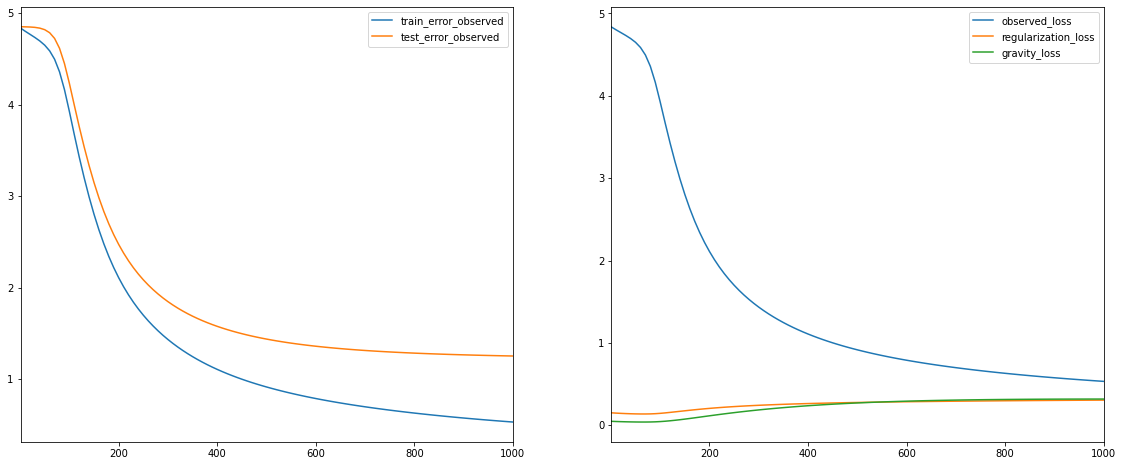

In [61]:
# We will take the same parameters as before.
reg_model = build_regularized_model(ratings_table, regularization_coeff=0.1,
                                    gravity_coeff=1.0, embedding_dim=12,init_stddev=.25)
reg_model.train(num_iterations=1000, learning_rate=10.)

We can see that the train and test loss has increased compared to our previous model. But the range between the train and test data is tighter in the regularised model. Meaning that the performance on the both seen and unseen is more consistent for the regularised. This is a good indication that it has not learnt the specifics of the features in the training set and has instead got a high-level view of the data that can better generalise to unseen data. 

+ Previous - train_error=0.146221, test_error=1.078422
+ Current - train_error_observed=0.532199, test_error_observed=1.253562

This highlights why regularisation is good for avoiding ovefitting.

We will have a quick look at the artists closest to Eminem and The Beatles as before.

In [167]:
artist_neighbors(reg_model, artists, "Eminem", measure="dot", k=6)

Nearest neighbors of : Eminem.
[Found more than one matching artist. Other candidates: Eminem & Royce Da 5'9", 50 Cent, Eminem, Ca$his & Lloyd Banks, DJ Messiah, 50 Cent And Eminem, Eminem feat. Drake, Kanye West, Lil Wayne, B.o.B feat. Eminem & Hayley Williams, Eminem ft. Xzibit & Nate Dogg, Eminem ft. Nate Dogg, Dr. Dre, Eminem Ft. Trick Trick, BOB, Hayley Williams and Eminem, \Eminem f_ Rihanna]


,dot score,name
83,6.011,Lady Gaga
469,5.754,Eminem
294,5.339,Katy Perry
283,5.256,Britney Spears
282,5.248,Rihanna
327,5.246,Avril Lavigne


In [168]:
artist_neighbors(reg_model, artists, "Eminem", measure="cosine", k=6)

Nearest neighbors of : Eminem.
[Found more than one matching artist. Other candidates: Eminem & Royce Da 5'9", 50 Cent, Eminem, Ca$his & Lloyd Banks, DJ Messiah, 50 Cent And Eminem, Eminem feat. Drake, Kanye West, Lil Wayne, B.o.B feat. Eminem & Hayley Williams, Eminem ft. Xzibit & Nate Dogg, Eminem ft. Nate Dogg, Dr. Dre, Eminem Ft. Trick Trick, BOB, Hayley Williams and Eminem, \Eminem f_ Rihanna]


,cosine score,name
469,1.000,Eminem
541,0.952,Kid Cudi
963,0.945,t.A.T.u.
294,0.933,Katy Perry
959,0.932,Armin van Buuren
322,0.930,David Guetta


In [169]:
artist_neighbors(reg_model, artists, "The Beatles", measure="dot", k=6)

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,dot score,name
221,5.571,The Beatles
184,5.165,Muse
223,5.041,The Killers
167,5.024,Placebo
222,5.018,Kings of Leon
59,4.986,Coldplay


In [170]:
artist_neighbors(reg_model, artists, "The Beatles", measure="cosine", k=6)

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,cosine score,name
221,1.000,The Beatles
222,0.976,Kings of Leon
214,0.976,Red Hot Chili Peppers
228,0.970,Nirvana
206,0.967,Bob Dylan
1233,0.967,The Beach Boys


It can be seen that the dot product for Eminem returns many popular artists, likely due to the large norm they have. The cosine similarity recommendations seem more relevant with Kid Cudi being a rapper.

For The Beatles, both sets of recommendations seem relevant with The Beach Boys, Bob Dylan, Kings of Leon, Red Hot Chili Peppers and The Killers all being neighbours.

## 2.3 Basic Retrieval Model

The following model is a basic retreival model built using tensorflow.

Retreival is typically an efficent process that narrows the scope of later components at ranking the candidates for recommendation. So here we will only look at the fact a user has listened to an artist.

It is likely that this model will not perform well, but it is a stepping stone into more advanced models.

In [188]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

!pip install -q tensorflow-recommenders
import tensorflow_recommenders as tfrs

In [189]:
ratings_table = full_user_artists.copy()

We need to convert the userID to a contiguous range for ease of training. We can also drop many fields and just keep the userID and artistName.

With these we can see what artists users listen to and make recommendations based on this.

In [190]:
# We can use np.unique(return_inverse=True) to get an array the same length as the input with the indexes
# of the first occurence of each unique value. Which is just what we need.
_, new_column = np.unique(ratings_table["userID"].values, return_inverse=True)
ratings_table["userID"] = new_column
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
ratings_table["artistID"] = new_column

In [191]:
ratings_table["userID"] = ratings_table["userID"].astype(str)
ratings_table.drop(["artistID", "weight", "url", "pictureURL"], axis=1, inplace=True)

We can convert this dataframe into a tensor using the from_tensor_slices method and specifying which columns or even just column to keep.

In [192]:
# Now we need to convert the data to a tensorflow data object so we can feed it into our model.
# First we will get a dictionary of the column names and all values. We can use this to create a tensor.
ratings_dict = {name: values for name, values in ratings_table.items()}
tensor_ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)
tensor_ratings = tensor_ratings.map(lambda x: {"userID": x["userID"],
                                        "artistName": x["name"]})

no_duplicates = ratings_table.drop_duplicates(subset="name")
# Repeat this for the artists so we can get their embeddings too
artist_dict = {name: values for name, values in no_duplicates.items()}
tensor_artists = tf.data.Dataset.from_tensor_slices(artist_dict)
tensor_artists = tensor_artists.map(lambda x: x["name"])

Split the data into a train and test set.

In [193]:
tf.random.set_seed(42)
shuffled = tensor_ratings.shuffle(92_834, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(70_000)
test = shuffled.skip(70_000).take(22_834)

Get the unique artist names and userIDs so we can create a lookup table for creating the embeddings for both of these features.

In [194]:
artist_names = tensor_ratings.batch(1_000_000).map(lambda x: x["artistName"])
user_ids = tensor_ratings.batch(1_000_000).map(lambda x: x["userID"])

unique_artist_names = np.unique(np.concatenate(list(artist_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

Below we can see the code used for the user and artist model as well as the method for computing loss. Once we compute the loss the model we inherit from manages the updating of weights.

The loss is based on checking for relevant recommendations in the top K returned recommendations. This is not very computationally expensive and the idea is that this model will retreive items that are somewhat relevant and another more complex and computationally heavy model will rank them more precisely.

In [195]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

artist_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_artist_names, mask_token=None),
  tf.keras.layers.Embedding(len(unique_artist_names) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=tensor_artists.batch(128).map(artist_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class LastFMModel(tfrs.Model):

  def __init__(self, user_model, artist_model):
    super().__init__()
    self.artist_model: tf.keras.Model = artist_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userID"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.artist_model(features["artistName"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

In [196]:
model = LastFMModel(user_model, artist_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [197]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Now we can call fit on our model and pass the training data.

In [198]:
model.fit(cached_train, epochs=3)

Epoch 1/3
9/9 [==============================] - 218s 22s/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categorical_accuracy: 0.0141 - factorized_top_k/top_10_categorical_accuracy: 0.0282 - factorized_top_k/top_50_categorical_accuracy: 0.0943 - factorized_top_k/top_100_categorical_accuracy: 0.1332 - loss: 66134.0953 - regularization_loss: 0.0000e+00 - total_loss: 66134.0953
Epoch 2/3
9/9 [==============================] - 172s 16s/step - factorized_top_k/top_1_categorical_accuracy: 0.0056 - factorized_top_k/top_5_categorical_accuracy: 0.0343 - factorized_top_k/top_10_categorical_accuracy: 0.0655 - factorized_top_k/top_50_categorical_accuracy: 0.2226 - factorized_top_k/top_100_categorical_accuracy: 0.3268 - loss: 62669.7086 - regularization_loss: 0.0000e+00 - total_loss: 62669.7086
Epoch 3/3
9/9 [==============================] - 164s 18s/step - factorized_top_k/top_1_categorical_accuracy: 0.0059 - factorized_top_k/top_5_categorical_accuracy: 0.0443

In [91]:
model.evaluate(cached_test, return_dict=True)

6/6 [==============================] - 50s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0189 - factorized_top_k/top_10_categorical_accuracy: 0.0406 - factorized_top_k/top_50_categorical_accuracy: 0.1863 - factorized_top_k/top_100_categorical_accuracy: 0.2916 - loss: 26571.9866 - regularization_loss: 0.0000e+00 - total_loss: 26571.9866


{'factorized_top_k/top_1_categorical_accuracy': 0.0021021284628659487,
 'factorized_top_k/top_5_categorical_accuracy': 0.01891915500164032,
 'factorized_top_k/top_10_categorical_accuracy': 0.04064114764332771,
 'factorized_top_k/top_50_categorical_accuracy': 0.1863449215888977,
 'factorized_top_k/top_100_categorical_accuracy': 0.291626513004303,
 'loss': 16323.79296875,
 'regularization_loss': 0,
 'total_loss': 16323.79296875}

We can see that the loss is reasonably high. This is due to the simplicity of the model. In addition, the model recommeneds items which the user has already seen/listened to. This can be changed if needed with some additional structure.

In [93]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.artist_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((tensor_artists.batch(100), tensor_artists.batch(100).map(model.artist_model)))
)

# Get recommendations.
_, artists = index(tf.constant(["0"]))
print(f"Recommendations for user 0: {artists[0, :5]}")

Recommendations for user 0: [b'Bob Dylan' b'Agalloch' b'The Roots' b'John Lennon' b'Iron & Wine']


Looking again at the recommendations for user 0, we can see Bob Dylan is a folk singer, Agalloch is a metal group and The Roots is a hip-hop group. As user 0 enjoyed punk, metal and hip-hop these recommendations are quite good.

## 2.4 Basic Rank Model

We will first need to normalise the user listens to be between 0 and 1 for a given user, this means that for each user we will get the a value of 1 for their more listened to artist and all other artists will be less than this but greater than 0.

In this way, each users implicit rating is normalised with respect to their own preferences and we are not passing absurdly large values to our model. We are however losing the number of listens, which is not the most important feature to discern which artists a user likes.

In [33]:
from sklearn.preprocessing import minmax_scale

def normalize_list_numpy(list_numpy):
    normalized_list = minmax_scale(list_numpy)
    return normalized_list

!pip install -q tensorflow-recommenders
import tensorflow_recommenders as tfrs

In [34]:
ratings_table = full_user_artists.copy()

Now we can normalize the ratings for each user.

In [35]:
# For each user, get their ratings and normalise them. Replace the values with the normalised ones.

for userID in ratings_table["userID"].unique():
  user_ratings = ratings_table[ratings_table["userID"] == userID]
  ratings_vector = np.asarray(user_ratings["weight"])

  normalizedData = normalize_list_numpy(ratings_vector)

  ratings_table.loc[ratings_table["userID"] == userID, "weight"] = normalizedData

In [36]:
# Check describe to see the min and max for the column. It seems all values are between 0 and 1
ratings_table.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.000000
mean,1037.010481,3331.123145,0.122843
std,610.870436,4383.590502,0.201068
min,2.000000,1.000000,0.000000
25%,502.000000,436.000000,0.010611
50%,1029.000000,1246.000000,0.042652
75%,1568.000000,4350.000000,0.136620
max,2100.000000,18745.000000,1.000000


It seems that this has worked as expected, the below users listens are all scaled to between 0 and 1.

In [37]:
ratings_table[ratings_table["userID"] == 2100].head()

,userID,artistID,weight,name,url,pictureURL
36171,2100,837,0.296997,Eluveitie,http://www.last.fm/music/Eluveitie,http://userserve-ak.last.fm/serve/252/23089827...
36283,2100,841,0.180756,Slayer,http://www.last.fm/music/Slayer,http://userserve-ak.last.fm/serve/252/10447745...
38365,2100,6,0.097887,Moonspell,http://www.last.fm/music/Moonspell,http://userserve-ak.last.fm/serve/252/2181591.jpg
43712,2100,1109,0.614572,Yann Tiersen,http://www.last.fm/music/Yann+Tiersen,http://userserve-ak.last.fm/serve/252/21942063...
43760,2100,1111,0.463849,Tenhi,http://www.last.fm/music/Tenhi,http://userserve-ak.last.fm/serve/252/5224.jpg


In [38]:
# We can use np.unique(return_inverse=True) to get an array the same length as the input with the indexes
# of the first occurence of each unique value. Which is just what we need.
_, new_column = np.unique(ratings_table["userID"].values, return_inverse=True)
ratings_table["userID"] = new_column
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
ratings_table["artistID"] = new_column

In [39]:
ratings_table["userID"] = ratings_table["userID"].astype(str)
ratings_table.drop(["artistID", "url", "pictureURL"], axis=1, inplace=True)

In [40]:
ratings_table

,userID,weight,name
0,0,1.000000,Duran Duran
1,2,0.007307,Duran Duran
2,24,0.077143,Duran Duran
3,25,0.150000,Duran Duran
4,59,0.068513,Duran Duran
...,...,...,...
92829,1891,0.060623,Nyktalgia
92830,1891,0.038376,Atsakau niekadA
92831,1891,0.029477,Domantas Razauskas
92832,1891,0.028921,Atalyja


This time we will be taking the weighting as we can afford to use a more computationally expensive approach as we have hopefull weeded out many items that do not match and have drastically reduced our workload for ranking.

In [41]:
# Now we need to convert the data to a tensorflow data object so we can feed it into our model.
# First we will get a dictionary of the column names and all values. We can use this to create a tensor.
ratings_dict = {name: values for name, values in ratings_table.items()}
tensor_ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)
tensor_ratings = tensor_ratings.map(lambda x: {"userID": x["userID"],
                                        "artistName": x["name"],
                                        "Weight": x["weight"]})

In [208]:
tf.random.set_seed(42)
shuffled = tensor_ratings.shuffle(92_834, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(70_000)
test = shuffled.skip(70_000).take(22_834)

In [209]:
artist_names = tensor_ratings.batch(1_000_000).map(lambda x: x["artistName"])
user_ids = tensor_ratings.batch(1_000_000).map(lambda x: x["userID"])

unique_artist_names = np.unique(np.concatenate(list(artist_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

Our model below is reasonably similar to before. The main different is the addition of dense layers with the RELU activation function. These will allow the model to make better use of the data and make more informed decisions on whether an item is relevant to recommend or not.

The lose used this time will be the root mean squared error between the ground truths and the predicted values for listens.

In [210]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.artist_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_artist_names, mask_token=None),
      tf.keras.layers.Embedding(len(unique_artist_names) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    user_id, artist_name = inputs

    user_embedding = self.user_embeddings(user_id)
    artist_embedding = self.artist_embeddings(artist_name)

    return self.ratings(tf.concat([user_embedding, artist_embedding], axis=1))

In [212]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [213]:
class LastFMModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["userID"], features["artistName"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("Weight")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [214]:
ranker = LastFMModel()
ranker.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [215]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Now we are ready to fit our ranking model.

In [216]:
ranker.fit(cached_train, epochs=3)

Epoch 1/3
9/9 [==============================] - 3s 105ms/step - root_mean_squared_error: 0.2065 - loss: 0.0423 - regularization_loss: 0.0000e+00 - total_loss: 0.0423
Epoch 2/3
9/9 [==============================] - 1s 63ms/step - root_mean_squared_error: 0.2006 - loss: 0.0403 - regularization_loss: 0.0000e+00 - total_loss: 0.0403
Epoch 3/3
9/9 [==============================] - 1s 59ms/step - root_mean_squared_error: 0.2005 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss: 0.0402


In [187]:
ranker.evaluate(cached_test, return_dict=True)

6/6 [==============================] - 2s 33ms/step - root_mean_squared_error: 0.2028 - loss: 0.0418 - regularization_loss: 0.0000e+00 - total_loss: 0.0418


{'root_mean_squared_error': 0.20279821753501892,
 'loss': 0.044403884559869766,
 'regularization_loss': 0,
 'total_loss': 0.044403884559869766}

Now we can take our test user 0 and get some random artists and see how they are ranked.

In [222]:
test_ratings = {}
artist_names = ["Eminem", "Metallica", "The Beach Boys", "The Killer", "Lady Gaga", "Bob Dylan"]
for artist_name in artist_names:
  test_ratings[artist_name] = ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Lady Gaga: [[0.12009619]]
Metallica: [[0.11722346]]
The Killer: [[0.1087604]]
Bob Dylan: [[0.10822719]]
Eminem: [[0.10668447]]
The Beach Boys: [[0.10369657]]


We can see that Lady Gaga and Metallica are at the top. Metallica and The Killers are artists I would have expected to be ranked well.

Now we can have a look at the users top-rated artists and see how the ranker does with those.

In [227]:
ratings_table[ratings_table["userID"] == "0"].sort_values("weight", ascending=False).head()

,userID,weight,name
0,0,1.000000,Duran Duran
111,0,0.825509,Morcheeba
134,0,0.798536,Air
209,0,0.714911,Hooverphonic
227,0,0.610121,Kylie Minogue


In [228]:
test_ratings = {}
artist_names = ["Duran Duran", "Morcheeba", "Air", "Hooverphonic", "Kylie Minogue"]
for artist_name in artist_names:
  test_ratings[artist_name] = ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for artist, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{artist}: {score}")

Ratings:
Kylie Minogue: [[0.1161214]]
Morcheeba: [[0.11206447]]
Duran Duran: [[0.11145407]]
Hooverphonic: [[0.09758022]]
Air: [[0.09574795]]


We can see that there is some slight issues with Kylie Minogue being ranked as the top-artist to recommend for this user. It has to be noted that all of these artists have similar scores for ranking. It may be worth adding in one of the artists this user did not listen to much.

In [230]:
ratings_table[ratings_table["userID"] == "0"].sort_values("weight").head()

,userID,weight,name
3603,0,0.000000,ABC
3554,0,0.001194,INXS
3532,0,0.001353,Japan
3452,0,0.001750,Duffy
3410,0,0.002148,Fleetwood Mac


In [231]:
test_ratings = {}
artist_names = ["Duran Duran", "ABC", "Air", "Fleetwood Mac", "Kylie Minogue"]
for artist_name in artist_names:
  test_ratings[artist_name] = ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for artist, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{artist}: {score}")

Ratings:
Fleetwood Mac: [[0.12116598]]
ABC: [[0.12036343]]
Kylie Minogue: [[0.1161214]]
Duran Duran: [[0.11145407]]
Air: [[0.09574795]]


This is unfortunate, it seems the ranker is not working as well as we would have liked. It may be worth letting the model train for longer and retesting this.

In [235]:
new_ranker = LastFMModel()
new_ranker.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.25))
new_ranker.fit(cached_train, epochs=100)

Epoch 1/100
9/9 [==============================] - 2s 66ms/step - root_mean_squared_error: 0.2166 - loss: 0.0460 - regularization_loss: 0.0000e+00 - total_loss: 0.0460
Epoch 2/100
9/9 [==============================] - 1s 71ms/step - root_mean_squared_error: 0.2005 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss: 0.0402
Epoch 3/100
9/9 [==============================] - 1s 71ms/step - root_mean_squared_error: 0.2005 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss: 0.0402
Epoch 4/100
9/9 [==============================] - 1s 64ms/step - root_mean_squared_error: 0.2005 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss: 0.0402
Epoch 5/100
9/9 [==============================] - 1s 61ms/step - root_mean_squared_error: 0.2005 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss: 0.0402
Epoch 6/100
9/9 [==============================] - 1s 71ms/step - root_mean_squared_error: 0.2004 - loss: 0.0402 - regularization_loss: 0.0000e+00 - total_loss:

In [236]:
new_ranker.evaluate(cached_test, return_dict=True)

6/6 [==============================] - 5s 99ms/step - root_mean_squared_error: 0.1983 - loss: 0.0399 - regularization_loss: 0.0000e+00 - total_loss: 0.0399


{'root_mean_squared_error': 0.1983036994934082,
 'loss': 0.042115144431591034,
 'regularization_loss': 0,
 'total_loss': 0.042115144431591034}

The loss on the test set seems marginally better. Let us try again and see if the results are any different.

In [240]:
test_ratings = {}
artist_names = ["Duran Duran", "Morcheeba", "Air", "Hooverphonic", "Kylie Minogue"]
for artist_name in artist_names:
  test_ratings[artist_name] = new_ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for artist, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{artist}: {score}")

Ratings:
Duran Duran: [[0.23208761]]
Kylie Minogue: [[0.13825351]]
Air: [[0.11046371]]
Hooverphonic: [[0.10777659]]
Morcheeba: [[0.0803777]]


In [238]:
test_ratings = {}
artist_names = ["Duran Duran", "ABC", "Air", "Fleetwood Mac", "Kylie Minogue"]
for artist_name in artist_names:
  test_ratings[artist_name] = new_ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for artist, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{artist}: {score}")

Ratings:
Duran Duran: [[0.23208761]]
Kylie Minogue: [[0.13825351]]
Fleetwood Mac: [[0.12766269]]
Air: [[0.11046371]]
ABC: [[0.07259845]]


These results seem much better for this user. There is definitly more tweaking that could be done and tuning of hyperparameters, but this is a good start.

## 2.5 Combining the Retrieval and Ranking

Now that we have both of the basic models running, we can make use of them in series to produce a better output. The retreival model taks the whole corpus of artists and roughly ranks them with a score. From this score we can take the top 100 artists for example, and pass these into our second model to rank them with more precision.

This method allows for more efficient recommendations as different levels of precision are taken depending on how much of the total data we are looking at. In this way, we can rank the items in an expensive way with the peace of mind that it will be on a very small subset of the data.

We will look at this process for 2 users, namely user 0 and user 42.

In [277]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.artist_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((tensor_artists.batch(17632), tensor_artists.batch(17632).map(model.artist_model)))
)

# Get recommendations.
_, artists = index(tf.constant(["0"]))
top_100 = artists[0, :100]

In [271]:
test_ratings = {}
for artist_name in top_100:
  artist_name = artist_name.numpy().decode("utf-8")
  test_ratings[artist_name] = ranker({
      "userID": np.array(["0"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
J Dilla: [[0.12852435]]
The Roots: [[0.12410604]]
Deerhoof: [[0.12305278]]
Tom Waits: [[0.11826345]]
Iron & Wine: [[0.1175797]]
John Lennon: [[0.11138511]]
Howlin' Wolf: [[0.11013536]]
Agalloch: [[0.10877389]]
Bob Dylan: [[0.10822719]]
Prefuse 73: [[0.10471152]]


We can see that User 0  has been recommended J Dilla is a hip-hop artist, The Roots are a hip-hop group and DeerHoof is a rock/punk band. Overall, it seems that these recommendations are relevant for user 0 and it is nice to see the models working together to shortlist and rank artists to recommend to a user.

In [288]:
ratings_table[ratings_table["userID"] == "42"].sort_values("weight", ascending=False).head()

,userID,weight,name
35459,42,1.000000,AnahÃ­
12161,42,0.579831,Rihanna
31011,42,0.399474,RBD
49301,42,0.387311,Dulce MarÃ­a
2765,42,0.200599,Lady Gaga


It seems from the above that user 42 likes pop music. So let us look at their recommendations and see whether they make sense.

In [292]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.artist_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((tensor_artists.batch(17632), tensor_artists.batch(17632).map(model.artist_model)))
)

# Get recommendations.
_, artists = index(tf.constant(["42"]))
top_100 = artists[0, :100]

In [293]:
test_ratings = {}
for artist_name in top_100:
  artist_name = artist_name.numpy().decode("utf-8")
  test_ratings[artist_name] = ranker({
      "userID": np.array(["42"]),
      "artistName": np.array([artist_name])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
The Roots: [[0.12961836]]
Agalloch: [[0.11439253]]
Bob Dylan: [[0.10817054]]


These don't seem to make sense here. It seems that the retreival model is serving back the same artists both times. This may be an error in the way I have set the model up or is just down to the implementation I have user to recommend using the model.

I will briefly look at using the model standalone against a large amount of artists.

In [296]:
test_ratings = {}
for artist_name in unique_artist_names:
  artist_name = artist_name.decode("utf-8")
  test_ratings[artist_name] = ranker({
      "userID": np.array(["42"]),
      "artistName": np.array([artist_name])
  })

# Very ad-hoc
i = 0
print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")
  i += 1
  if i == 10:
    break

Ratings:
Mat Kearney: [[0.160909]]
Here Comes The Kraken: [[0.16077629]]
127 Band: [[0.1594393]]
Los Paranoias: [[0.15745813]]
And One: [[0.15705672]]
Alex Goot: [[0.15656254]]
ÐÑÑ: [[0.15632421]]
Tribraco: [[0.1561625]]
J Dilla: [[0.15611905]]
Museo Rosenbach: [[0.1559436]]


Computationally this took much longer, but the results seem much more relevant. There must be some issue with the retreival model, but the ranking seems to be working quite well.

We will see if we can implement some more features and serve recommendations up using data input to this notebook.

## 2.6 Advanced Retrieval Model

This model will make use of the features we used before with the addition of the tag and timestamp.

To add these we will need to be creative. The data we have currently reflects a user and their listening habit relating to one artist. So to include tag and timestamp we can look at the most popular tag for an artist and the timestamp the user added this tag. If they haven't added this tag we can take the average timestamp for this tag. 

This will avoid leaving the values empty and should hopefully be a reasonable approximation. In reality, these features are not very relevant, but they are the only additional features we have.

In the situation where the artist has no tags we cannot assign a timestamp to the listening record so this will be the global average.

In [66]:
import numpy as np
import tensorflow as tf

!pip install -q tensorflow-recommenders
import tensorflow_recommenders as tfrs

In [46]:
ratings_table = full_user_artists.copy()

In [47]:
artist_tag = {}

# for every artist, count all their tags and take the most popular into our mapping
for artist in tags_timestamp["artistID"].unique():
  artists_tags_df = tags_timestamp[tags_timestamp["artistID"] == artist]
  values, counts = np.unique(artists_tags_df["tagValue"].values, return_counts=True)
  most_used = values[counts == counts.max()]
  most_popular_tag = most_used[0]
  average_timestamp = artists_tags_df[artists_tags_df["tagValue"] == most_popular_tag]["timestamp"].mean()
  user_timestamps = {k:v for k, v in artists_tags_df[artists_tags_df["tagValue"] == most_popular_tag][["userID", "timestamp"]].values}
  artist_tag[artist] = (most_popular_tag, average_timestamp, user_timestamps)


global_timestamp = tags_timestamp["timestamp"].mean()

def map_tags(artist):
  if artist in artist_tag.keys():
    return artist_tag[artist][0]
  else:
    return "No Tag"

def map_timestamps(artist, user):
  if artist in artist_tag.keys():

    if user in artist_tag[artist][2].keys():
      return artist_tag[artist][2][user]

    else:
      return artist_tag[artist][1]

  else:
    return global_timestamp
  



In [49]:
ratings_table["Tag"] = ratings_table["artistID"].apply(lambda x: map_tags(x))
ratings_table["Timestamp"] = ratings_table.apply(lambda x: map_timestamps(x["artistID"], x["userID"]), axis=1)

In [50]:
# We can use np.unique(return_inverse=True) to get an array the same length as the input with the indexes
# of the first occurence of each unique value. Which is just what we need.
_, new_column = np.unique(ratings_table["userID"].values, return_inverse=True)
ratings_table["userID"] = new_column
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
ratings_table["artistID"] = new_column

In [52]:
ratings_table["userID"] = ratings_table["userID"].astype(str)
ratings_table["artistID"] = ratings_table["artistID"].astype(str)
ratings_table["Timestamp"] = ratings_table["Timestamp"].astype(int)

ratings_table.drop(["url", "pictureURL"], axis=1, inplace=True)

In [105]:
# Now we need to convert the data to a tensorflow data object so we can feed it into our model.
# First we will get a dictionary of the column names and all values. We can use this to create a tensor.
ratings_dict = {name: values for name, values in ratings_table.items()}
tensor_ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)
tensor_ratings = tensor_ratings.map(lambda x: {"userID": x["userID"],
                                        "artistName": x["name"],
                                        "Tag": x["Tag"],
                                        "Timestamp": x["Timestamp"]})

no_duplicates = ratings_table.drop_duplicates(subset="Tag")
# Repeat this for the artists so we can get their embeddings too
artist_dict = {name: values for name, values in no_duplicates.items()}
tensor_artists = tf.data.Dataset.from_tensor_slices(artist_dict)
tensor_artists = tensor_artists.map(lambda x: x["Tag"])

no_duplicates = ratings_table.drop_duplicates(subset="Tag")
# Repeat this for the artists so we can get their embeddings too
tag_dict = {name: values for name, values in no_duplicates.items()}
tensor_tags = tf.data.Dataset.from_tensor_slices(tag_dict)
tensor_tags = tensor_tags.map(lambda x: x["Tag"])

In [137]:
tf.random.set_seed(42)
shuffled = tensor_ratings.shuffle(92_834, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(70_000)
test = shuffled.skip(70_000).take(22_834)

Now we will do some setup for our model. We need to compute the buckets for the timestamps to fit into. This is because currently our timestamps are large integers and turning these into discrete values will benefit our model.

In [93]:
timestamps = np.concatenate(list(tensor_ratings.map(lambda x: x["Timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_artist_names = np.unique(np.concatenate(list(tensor_ratings.batch(1_000).map(
    lambda x: x["artistName"]))))
unique_tags = np.unique(np.concatenate(list(tensor_ratings.batch(1_000).map(
    lambda x: x["Tag"]))))
unique_user_ids = np.unique(np.concatenate(list(tensor_ratings.batch(1_000).map(
    lambda x: x["userID"]))))

Now we can create our user model for creating a representation of our user.

In [88]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["userID"]),
        self.timestamp_embedding(inputs["Timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["Timestamp"]), (-1, 1)),
    ], axis=1)

We can see that below our user representation is computed as expected.

In [127]:
user_model = UserModel()

user_model.normalized_timestamp.adapt(
    tensor_ratings.map(lambda x: x["Timestamp"]).batch(128))

for row in tensor_ratings.batch(1).take(1):
  print(f"Computed representations: {user_model(row)[0, :3]}")

Computed representations: [ 0.0311793   0.00263394 -0.0005692 ]


Now we can create a QueryModel that will take this UserModel and add dense layers following it.

In [89]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

Now we can create a similar representation for the artists.This will be fed in to our model and updated based on the loss.

In [133]:
class ArtistModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.artist_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_artist_names,mask_token=None),
      tf.keras.layers.Embedding(len(unique_artist_names) + 1, 32)
    ])

    self.tag_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.tag_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.tag_vectorizer.adapt(tensor_tags)

  def call(self, string):
    return tf.concat([
        self.artist_embedding(string),
        self.title_text_embedding(string),
    ], axis=1)

The representation of the artist can be seen below, it takes the artist name and Tag into account.

In [129]:
artist_model = ArtistModel()

artist_model.title_text_embedding.layers[0].adapt(
    tensor_ratings.map(lambda x: x["artistName"]))

for row in tensor_ratings.batch(1).take(1):
  print(f"Computed representations: {artist_model(row)[0, :3]}")

Computed representations: [0.02347267 0.00649219 0.01640055]


In [132]:
class CandidateModel(tf.keras.Model):
  """Model for encoding artists."""

  def __init__(self, layer_sizes):
    """Model for encoding artists.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = ArtistModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

Now we can take the Query and Candidate model and create a Combined model. This will compute the loss and optimise for the task.

In [135]:
class LastFMModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=tensor_artists.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "userID": features["userID"],
        "Timestamp": features["Timestamp"],
    })
    artist_embeddings = self.candidate_model(features["artistName"])

    return self.task(
        query_embeddings, artist_embeddings, compute_metrics=not training)

In [138]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [140]:
num_epochs = 3

model = LastFMModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

KeyError: ignored

In [141]:
model.evaluate(cached_test)

6/6 [==============================] - 6s 823ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: nan - regularization_loss: 0.0000e+00 - total_loss: nan


[0.0, 0.0, 0.0, 0.0, 0.0, nan, 0, nan]

After troublshooting this model setup for some time I was unable to get the model to work as intended. There seems to be issues with the Tag value being passed from the combined model through to the ArtistModel.

The ArtistModel will only accept one value, but there are two I would like to set. Unfortunately I had to settle with the vectorizer making use of the artist name.

After checking the data there doesn't seem to be any issues with the Tag column. So it isn't clear where exactly between the models the error is occurring.

Regardless, we have transformed the features and got a representation of them to show. The model has not produced any meaningful output with the error from the inputs, so there is not anythong to show in terms of metrics.

## 2.7 Conclusion

I have found creating these models quite interesting. It is difficult at first to fit the components together in Tensorflow, but as I have gone through training these models I have got a better grasp.

I had hoped to have a look at using the user releationships to get more information from the data but I was unsure how I could plug them in.

I wanted to try and create a representation of the users friend group by getting the average of all of the friend latent representations. My understanding would be that the user will be influenced by all these friends in the direction of that vector.

I have definitely become more familiar with using Tensorflow and have got a better grasp of what considerations there are for building a recommender.

# Section 3 - New User Recommendations

We will make use of Streamlit to create a webpage for entering artists and listening scores. This can then be used to create a full user vector.

Taking this with the item-matrix gives us an approxiamte latent representation of the user vector. With this we can compute the recommendations for a user. We will take the basic model 

## 3.1 Streamlit GUI

I will be making use of some of a streamlit application that I have made before with some tweaks to display the information we want.

We will need to save the artist embeddings and the list of all artists and their ids. This will have to be done following the same technique use in data preperation so that the IDs match between the embeddings and the item dictionary.

In [ ]:
!pip install streamlit
!pip install pyngrok==4.1.1

In [ ]:
!pip install protobuf --upgrade

In [9]:
import pickle
import streamlit as st
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501

!ngrok authtoken #ngrok authentication key

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [39]:
artist_embeddings = matrix_fac.embeddings["artistID"]

In [41]:
ratings_table = full_user_artists.copy()

In [42]:
_, new_column = np.unique(ratings_table["artistID"].values, return_inverse=True)
old_column = ratings_table["artistID"].values
old_new_mapping = {k:v for k, v in zip(old_column, new_column)}

ratings_table["artistID"] = new_column

In [43]:
artist_dict = {k: v for k, v in ratings_table[["artistID", "name"]].values}

In [51]:
with open('drive/MyDrive/CA4015/embeddings.pickle', 'wb') as p:
      pickle.dump(artist_embeddings, p, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
with open('drive/MyDrive/CA4015/artists.pickle', 'wb') as p:
      pickle.dump(artist_dict, p, protocol=pickle.HIGHEST_PROTOCOL)

### Streamlit file

The streamlit file can be found [here](https://github.com/teg-lad/CA4015-LastFM-Recommender) in the git repository for this assignment. 

It will load the embedding and load the artists.

The user can select what artist they would like to rate from a dropdown. They can then proceed to rate the artists, preferably by using the range outlined earlier.

+ 0 - A user has not listened to an artist
+ 1 - A user has listened to an artist once
+ 2 - A user has listened to an artist 2-1000 times
+ 3 - A user has listened to an artist 1001-10000 times
+ 4 - A user has listened to an artist 10001-50000 times
+ 5 - A user has listened to an artist 50000+ times

Once the user select compute recommendation, the ratings are turned into a sparse vector, multiplied by the artist embeddings to get the appoximate user embedding and then by the transpose of the artist embeddings to get the recommendations.



In [13]:
!streamlit run --server.port 8501 recommender.py &>/dev/null&

In [27]:
# Check that streamlit is running
!pgrep streamlit

6146


In [28]:
# Create a tunnel to connect to streamlit
public_url = ngrok.connect(port='8501')

INFO:pyngrok.process:ngrok process starting: 6249
2022-12-15 22:35:34.651 INFO    pyngrok.process: ngrok process starting: 6249
INFO:pyngrok.process:t=2022-12-15T22:35:34+0000 lvl=info msg="no configuration paths supplied"

2022-12-15 22:35:34.674 INFO    pyngrok.process: t=2022-12-15T22:35:34+0000 lvl=info msg="no configuration paths supplied"

INFO:pyngrok.process:t=2022-12-15T22:35:34+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2022-12-15 22:35:34.678 INFO    pyngrok.process: t=2022-12-15T22:35:34+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

INFO:pyngrok.process:t=2022-12-15T22:35:34+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2022-12-15 22:35:34.685 INFO    pyngrok.process: t=2022-12-15T22:35:34+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

INFO:pyngrok.process:t=2022-12-15T22:35:34+0000 lvl=info msg="starting web service" obj=

In [29]:
public_url

'http://af40-35-237-92-37.ngrok.io'

The recommendations from streamlit can be seen in the repo for this assignment.

# Section 4 - Conclusion

Overall, I am happy with the range of models that I have now got experience training. I have not previosuly made use of tensorflow, so understanding how to convert the data into a format that was suitable was difficult.

The processes in tensorflow are in now way difficult to understand, it is just a matter of being unfamiliar with the package as a whole and what it has to offer. Having a solid understanding of the basic made understanding the notes on recommender quite understandable.

I had hoped to have time to look into creating a recommender using Tensorflow lite but that will have to be a personal project for me to take on instead. The various models are by new means production ready, but there are clear results from only a minimal amount of tweaking from each model and a reasonably small dataset.

